# Thesis ABM model

Network model between agents that creates stochastic payment shocks then settles payments. Agents are affliliated to a bank. If with the same bank, settlement occurs in period. If with different bank, payment occurs every fourth period due to "batching".

## Configuring the model

In the Black Rhino framework, parameters are stored in xml files. Using this notebook, you can set change them. First, you need to import the elementree from the xml Python module.

In [54]:
import xml.etree.ElementTree as ET

Below you will find the parameter inputs for this model. Change the parameter values for different configurations of the model.

In [55]:
parameter_values = (('num_sweeps', '20'),
                    ('num_simulations', '1'),
                    ('num_households', '32'),
                    ('num_firms', '8'),
                    ('num_banks', '4'),
                    ('num_central_bank', '1'),
                    ('batch', '1'),
                    ('household_directory', 'agents/gen_households/'),
                    ('firm_directory', 'agents/gen_firms/'),
                    ('bank_directory', 'agents/gen_banks/'),
                    ('central_bank_directory', 'agents/central_bank/'),
                    ('measurement_config', 'measurements/test_output.xml')
                   )

To translate this to an xml document, which the framework can read, we first need create an ET element. 

In [56]:
environment = ET.Element('environment', identifier = "CBDC_parameters")

And create parameter elements and give them the values seen below to add to the tree object.

In [57]:
parameters = []
for x in range(len(parameter_values)):
    parameters.append(ET.SubElement(environment, 'parameter'))
    
for idx, p in enumerate(parameters):
    p.set('type', 'static')
    p.set('name', parameter_values[idx][0])
    p.set('value', parameter_values[idx][1])

This object can now be transformed to a string and written to an xml file using the code below. 

In [58]:
xml_params = ET.tostring(environment, encoding="UTF-8")
myfile = open("environments/CBDC_parameters.xml", "w")
xml_params = "<?xml version='1.0' encoding='UTF-8'?>\n" + str(xml_params, encoding = "UTF-8")
myfile.write(xml_params)
myfile.close()

Now, the parameter xml file has been generated and the model can be run. Before, running the model, you need to import a couple of extra modules. These are the Python logging module, the Black Rhino environment class, and the Black Rhino runner class.

In [59]:
import logging
import os
from src.environment import Environment
from src.runner import Runner

Then, before running the model, the logger needs to be initialized.

In [60]:
log_directory = "log/"
identifier = "/CBDC_parameters"
environment_directory = "environments/"
if not os.path.exists('log'):
    os.makedirs('log')
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    filename=log_directory + identifier + ".log", level=logging.INFO)
logging.info('START logging for run: %s',  environment_directory + identifier + ".xml")

Generate banks and households using the generate agents class. First remove any agents still in directories. Then generate agents, the number of households and banks needs to be specified. In the generate banks method, the number of banks is the second argument. In the generate households method, the number of households it the second argument and the number of banks is the thrid argument.

In [61]:
import os
remove = True

bank_dir = os.getcwd()+'/agents/gen_banks/'
house_dir = os.getcwd()+'/agents/gen_households/'
firm_dir = os.getcwd()+'/agents/gen_firms/'
if remove:
    bank_list = [ f for f in os.listdir(bank_dir) if f.startswith("bank") ]
    house_list = [ f for f in os.listdir(house_dir) if f.startswith("house") ]
    firm_list = [ f for f in os.listdir(firm_dir) if f.startswith("firm") ]
for f in bank_list:
    os.remove(os.path.join(bank_dir, f))
for f in house_list:
    os.remove(os.path.join(house_dir, f))
for f in firm_list:
    os.remove(os.path.join(firm_dir, f))

In [62]:
from src.br_generate_agents import Generate_Agents
gen_agents = Generate_Agents()

gen_agents.generate_households(parameter_values[2][1], "./agents/gen_households/")

gen_agents.generate_firms(parameter_values[3][1], "./agents/gen_firms/")

gen_agents.generate_banks(parameter_values[4][1], "./agents/gen_banks/")

First, the environment will be initialized. It contains the model parameters and variables. The environment also contains a list of agents. In the Solow model, the environment contains one bank, one firm, and one household. Finally, it also contains initialized transactions for these agents.

In [63]:
environment = Environment(environment_directory, identifier)

Next up, the runner object is created. As the name suggests, the runner object handles the running of the model. But that is not all, it also initializes the updater.

In [64]:
runner = Runner(environment)

Now you can actually run the model. Since the agent-based model is simulated using Monte Carlo methods. This means that the model will be run multiple times (num_simulations). For every simulation run, the environment and runner will be (re-)initialized. Then, the runner will run the Solow model. During the run, the runner will write data about capital to a csv file specified within the Measurement class and print out all the transactions happening and the books of firm and household at the end of each sweep.

In [65]:
for i in range(int(environment.num_simulations)):
    logging.info('  STARTED with run %s',  str(i))
    environment.initialize(environment_directory,  identifier)
    runner.initialize(environment)
    
    runner.do_run(environment)
    logging.info('  DONE')

measurements/test_output.xml
{'firm_4': {'assets': {'fixed_assets': 10.0, 'deposits': 0.0, 'cbdc': 0.0, 'wage_agreement': 0.0}, 'liabilities': {'capital_firm': 10.0, 'loans': 0.0, 'output_agreement': 0.0}}}
10.0 new loan from bank_0 to firm_4 for capitalizing bank
{'bank_0': {'assets': {'loans': 10.0, 'reserves': 0.0}, 'liabilities': {'capital_bank': 10.0, 'deposits': 0.0, 'open_market_operations': 0.0}}}
{'household_7': {'assets': {'capital_firm': 10.0, 'capital_bank': 10.0, 'deposits': 0.0, 'cbdc': 0.0, 'bank_notes': 0.0, 'output_agreement': 0.0}, 'liabilities': {'equity': 20.0, 'loans': 0.0, 'wage_agreement': 0.0}}}
household_7 took out new loan of 20.0 at bank_0
{'bank_0': {'assets': {'loans': 30.0, 'reserves': 0.0}, 'liabilities': {'capital_bank': 10.0, 'deposits': 20.0, 'open_market_operations': 0.0}}}
{'household_7': {'assets': {'capital_firm': 10.0, 'capital_bank': 10.0, 'deposits': 20.0, 'cbdc': 0.0, 'bank_notes': 0.0, 'output_agreement': 0.0}, 'liabilities': {'equity': 20.0, 

Check to see if all agents balance sheets are consistent

In [66]:
house = True
for houses in environment.households:
    house *= houses.check_consistency()
if house:
    print("All households have consistent balance sheets")
else:
    print("Not all households have consistent balance sheets")

firm = True
for firms in environment.firms:
    firm *= firms.check_consistency()
if firm:
    print("All firms have consistent balance sheets")
else:
    print("Not all firms have consistent balance sheets")

bank = True
for banks in environment.banks:
    bank *= banks.check_consistency()
if bank:
    print("All banks have consistent balance sheets")
else:
    print("Not all banks have consistent balance sheets")

if environment.central_bank[0].check_consistency():
    print("Central Bank has consistent balance sheets")
elif environment.central_bank[0].check_consistency() is False:
    print("Central Bank does not consistent balance sheets")

All households have consistent balance sheets
All firms have consistent balance sheets
All banks have consistent balance sheets
Central Bank has consistent balance sheets


In [67]:
import pandas as pd

house = environment.households[0]
balance_sheet = house.balance_sheet()
mark = pd.DataFrame.from_dict(balance_sheet[house.identifier], orient="columns")
print(f"{house.identifier} balance sheet")
print(mark)

firm = environment.firms[0]
balance_sheet = firm.balance_sheet()
mark = pd.DataFrame.from_dict(balance_sheet[firm.identifier], orient="columns")
print(f"{firm.identifier} balance sheet")
print(mark)

bank = environment.banks[0]
balance_sheet = bank.balance_sheet()
mark = pd.DataFrame.from_dict(balance_sheet[bank.identifier], orient="columns")
print(f"{bank.identifier} balance sheet")
print(mark)

central_bank = environment.central_bank[0]
balance_sheet = central_bank.balance_sheet()
mark = pd.DataFrame.from_dict(balance_sheet[central_bank.identifier], orient="columns")
print(f"{central_bank.identifier} balance sheet")
print(mark)

household_7 balance sheet
                     assets  liabilities
capital_firm      10.000000          NaN
capital_bank      10.000000          NaN
deposits           6.919018          NaN
cbdc               3.599033          NaN
bank_notes         0.000000          NaN
output_agreement   0.000000          NaN
equity                  NaN    10.518051
loans                   NaN    20.000000
wage_agreement          NaN     0.000000
firm_5 balance sheet
                  assets  liabilities
fixed_assets       120.0          NaN
deposits            20.0          NaN
cbdc                10.0          NaN
wage_agreement       0.0          NaN
capital_firm         NaN         60.0
loans                NaN         90.0
output_agreement     NaN          0.0
bank_0 balance sheet
                           assets  liabilities
loans                   300.00000          NaN
reserves                694.92844          NaN
capital_bank                  NaN     80.00000
deposits                      

In [68]:
import pandas as pd
thesis_data = pd.read_csv('measurements/TestMeasurement.csv', index_col=0) 

In [69]:
print(thesis_data.head(3))
print(thesis_data.tail(4))

      Deposit Balance         B_0         B_1         B_2   B_3  B_4  \
Step                                                                   
1               320.0  120.000000  170.000000  100.000000  90.0  NaN   
2               320.0  120.000000  170.000000  100.000000  90.0  NaN   
3               320.0  119.596746  168.628221  101.775032  90.0  NaN   

      Total_Payments  CBDC Balance  Batch Balance  CBDC_Payments  \
Step                                                               
1           0.000000         320.0            0.0       0.000000   
2          85.757818         320.0            0.0      48.207647   
3         177.902735         320.0            0.0     112.942900   

      Deposits_Payments  Total_Output  
Step                                   
1              0.000000           0.0  
2             37.550171        3200.0  
3             64.959835        6400.0  
      Deposit Balance         B_0         B_1         B_2         B_3  B_4  \
Step                

Check consistency of Households, Banks and Central Bank

In [70]:
import matplotlib.pyplot as plt

/var/folders/nx/sfr0g06x255301jlc_nyn7c00000gn/T/ipykernel_8534/1081937997.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  ax.plot(thesis_data.index, thesis_data.drop(["Total_Payments", "CBDC Balance", "Batch Balance", "CBDC_Payments", "Deposits_Payments", "Total_Output"], 1))


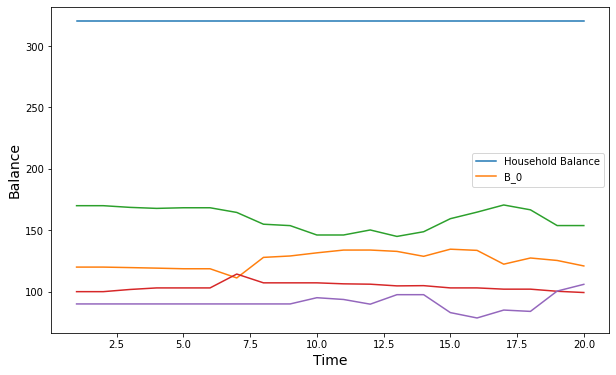

In [71]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

ax.plot(thesis_data.index, thesis_data.drop(["Total_Payments", "CBDC Balance", "Batch Balance", "CBDC_Payments", "Deposits_Payments", "Total_Output"], 1))
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['Household Balance', 'B_0'])#, 'B_1']) #, 'B_2', 'B_3', 'B_4'])

fig.savefig('deposit_balances.png')

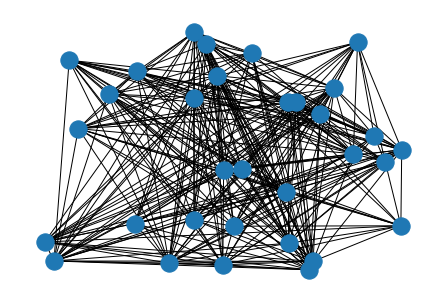

In [95]:
import networkx as nx
nx.draw_random(environment.social_network)

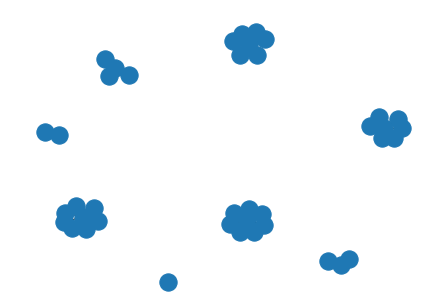

In [94]:
import networkx as nx
nx.draw(environment.employment_network)

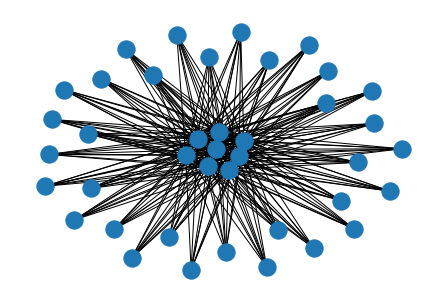

In [93]:
import networkx as nx
nx.draw(environment.consumption_network)

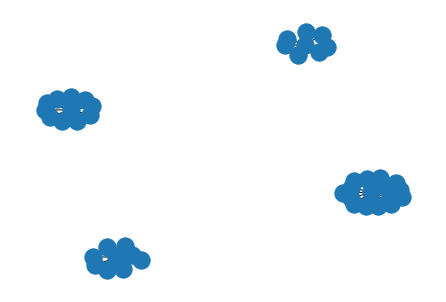

In [99]:
import networkx as nx
nx.draw(environment.bank_network)

In [76]:
for house in environment.households:
    print(f"{house.identifier} {house.supply}")

for firm in environment.firms:
    print(f"{firm.identifier} {firm.supply}")

household_7 0.0
household_6 0.0
household_4 0.0
household_5 0.0
household_1 0.0
household_0 0.0
household_2 0.0
household_3 0.0
household_16 0.0
household_17 0.0
household_29 0.0
household_15 0.0
household_14 0.0
household_28 0.0
household_10 0.0
household_11 0.0
household_13 0.0
household_12 0.0
household_23 0.0
household_22 0.0
household_20 0.0
household_21 0.0
household_31 0.0
household_25 0.0
household_19 0.0
household_18 0.0
household_24 0.0
household_30 0.0
household_26 0.0
household_27 0.0
household_8 0.0
household_9 0.0
firm_5 0.0
firm_4 0.0
firm_6 0.0
firm_7 0.0
firm_3 0.0
firm_2 0.0
firm_0 0.0
firm_1 0.0


In [77]:
eq_sum = 0
for house in environment.households:
    equity = house.get_account("equity")
    eq_sum += equity
    print(f"{house.identifier} {equity}")
print(eq_sum)

household_7 10.518051000413028
household_6 24.39244186247714
household_4 13.384184333708486
household_5 20.109200562816834
household_1 10.404699263770151
household_0 14.832398447611403
household_2 23.35672715122824
household_3 11.197266602803873
household_16 13.615525223315391
household_17 25.930698590409982
household_29 52.21122196438625
household_15 12.657932831238107
household_14 21.25338344841502
household_28 12.058024316876171
household_10 15.687984033029586
household_11 21.74878566814129
household_13 9.933525532347364
household_12 8.33097976726026
household_23 14.045017592346316
household_22 32.544592812169675
household_20 21.151546006628458
household_21 15.525166929081491
household_31 34.24798560018516
household_25 28.16524230083539
household_19 30.210120650471538
household_18 22.394292783720672
household_24 26.453080135496243
household_30 27.933784030676346
household_26 13.62452744721394
household_27 18.84794941323738
household_8 13.925607300847364
household_9 19.30805639684141